# AUTHORSHIP RECOGNITION PIPELINE

### Imports

In [1]:
# MATHEMATICAL LIBs
import numpy as np
from scipy import stats
from scipy.spatial import distance
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D

# NLP LIBs
import nltk

# OS LIBs
import glob
import os
import shutil
import sys

## FEATURE EXTRACTION

### Functions for feature extraction

In [2]:
def get_letter_freq(words,letter):
    freq = [elem[1] for elem in words if elem[0] == letter]
    
    if not freq:
        return 0
    else:
        return freq[0]


def extract_features(path):
    alphabet = ['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z']
    punctuation = ['?',',','!','.',':',';']

    ### CHARS ###
    input_file = sc.textFile(path)

    letters = (
                input_file
                .flatMap(lambda line: list(line.lower().replace(" ","")))
                .map(lambda x: (x, 1))
                .reduceByKey(lambda freq1, freq2: freq1 + freq2)
                .sortByKey(True)
             )
    letters = letters.collect()

    tot_chars = sum(elem[1] for elem in letters)
    tot_punctuation = sum(elem[1] for elem in letters if elem[0] in punctuation)

    alphabet_frequency = np.array([get_letter_freq(letters,letter) for letter in alphabet])
    alphabet_frequency=alphabet_frequency/tot_chars

    punctuation_frequency = np.array([get_letter_freq(letters,punct) for punct in punctuation])
    punctuation_frequency =punctuation_frequency/tot_punctuation

    ### WORDS ###

    words = (
                input_file
                .flatMap(lambda x: nltk.word_tokenize(x))
                .map(lambda x: (nltk.pos_tag([x],tagset='universal')[0][1],1))
                .reduceByKey(lambda freq1, freq2: freq1 + freq2)
                .sortByKey(True)
            )

    pos_frequency = words.collect()

    pos_ratios = [0] * 8

    for elem in pos_frequency:
            if 'DET' == elem[0]:
                pos_ratios[0] += elem[1]
            elif 'ADP' == elem[0]:
                pos_ratios[1] += elem[1]
            elif 'PRON' == elem[0]:
                pos_ratios[2] += elem[1]
            elif 'VERB' == elem[0]:
                pos_ratios[3] += elem[1]
            elif 'ADV' == elem[0]:
                pos_ratios[4] += elem[1]
            elif 'CONJ' == elem[0]:
                pos_ratios[5] += elem[1]
            elif 'NOUN' == elem[0]:
                pos_ratios[6] += elem[1]
            elif 'ADJ' == elem[0]:
                pos_ratios[7] += elem[1]


    tot_words = sum(elem[1] for elem in pos_frequency)

    pos_ratios = np.array(pos_ratios)
    pos_ratios = pos_ratios/tot_words

    lexical_variety = sum(elem[1] for elem in pos_frequency if (elem[0]=='NOUN' or 
                                                                elem[0]=='ADJ'  or 
                                                                elem[0]=='VERB' or 
                                                                elem[0]=='ADV' ) ) / tot_words

    tot_sentences = len(nltk.sent_tokenize(open(path).read()))

    avg_sentence_len = tot_words / tot_sentences

    avg_word_len = tot_chars / tot_words

    feature_vector = []

    feature_vector.extend(alphabet_frequency)
    feature_vector.extend(punctuation_frequency)
    feature_vector.extend(pos_ratios)
    feature_vector.extend([lexical_variety])
    feature_vector.extend([avg_sentence_len])
    feature_vector.extend([avg_word_len])
    feature_vector.extend([tot_words])

    feature_vector = np.array(feature_vector)
    
    return feature_vector


### Extracting features from training set and test set
It's not necessary to execute this cell since the computation has been done and its results are in the .txt files

In [1]:
### FEATURE EXTRACTION  TRAINING SET ###
n_features = 44
train_set_samples = 2269

training_set = np.zeros((n_features,train_set_samples))
home_dir = os.environ["HOME"]

# AUTHORS
authors_train = [authors.replace(home_dir+ "/AuthorshipRecognition/training_set/","") 
           for authors in glob.glob(home_dir + "/AuthorshipRecognition/training_set/*")]
authors_train.sort()
n_authors_train = len(authors_train)

# BOOKS PER AUTHOR
books_per_author_train = []
for author in authors_train:
    books_per_author_train.extend([(author,len(glob.glob(home_dir + "/AuthorshipRecognition/training_set/" + author + "/*")))])
    
# BUILDING TRAINING SET
index = 0
for author,n_books in books_per_author_train:
    for book in glob.glob(home_dir + "/AuthorshipRecognition/training_set/" + author + "/*.txt"):
        training_set[:,index] = extract_features(book)
        index+=1
        
# BUILDING TRAINING SET LABELS
train_set_labels = []
for i in range(0,len(books_per_author_train)):
    train_set_labels.extend(np.ones(books_per_author_train[i][1]) *(i+1))
    
train_set_labels = np.array(train_set_labels)



### FEATURE EXTRACTION  TEST SET ###
test_set_samples = 445

test_set = np.zeros((n_features,test_set_samples))
home_dir = os.environ["HOME"]

# AUTHORS
authors_test = [authors.replace(home_dir+ "/AuthorshipRecognition/test_set/","") 
           for authors in glob.glob(home_dir + "/AuthorshipRecognition/test_set/*")]
authors_test.sort()
n_authors_test = len(authors_test)

# BOOKS PER AUTHOR
books_per_author_test = []
for author in authors_test:
    books_per_author_test.extend([(author,len(glob.glob(home_dir + "/AuthorshipRecognition/test_set/" + author + "/*")))])
    
# BUILDING TEST SET
index = 0
for author,n_books in books_per_author_test:
    for book in glob.glob(home_dir + "/AuthorshipRecognition/test_set/" + author + "/*.txt"):
        test_set[:,index] = extract_features(book)
        index+=1
        
# BUILDING TEST SET LABELS
test_set_labels = []
for i in range(0,len(books_per_author_test)):
    test_set_labels.extend(np.ones(books_per_author_test[i][1]) *(i+1))
    
test_set_labels = np.array(test_set_labels)

### Saving/Reading resulted datasets from feature extraction

In [3]:
### SAVING RESULTS, COMPUTATION REQUIRES 2,5 h ###

#with open('test_set.txt','w') as f:
#        np.savetxt(f, test_set, fmt='%.6f')
#
#with open('test_set_labels.txt','w') as f:
#        np.savetxt(f, test_set_labels, fmt='%.6f')
#        
#with open('training_set.txt','w') as f:
#        np.savetxt(f, training_set, fmt='%.6f')
#        
#with open('train_set_labels.txt','w') as f:
#        np.savetxt(f, train_set_labels, fmt='%.6f')

np.set_printoptions(threshold=sys.maxsize)

### READING MATRICES ###
n_features = 44
train_set_samples = 2269
test_set_samples = 445

# READING TRAINING SET MATRIX
training_set_file = open('training_set.txt','r')

training_set = np.zeros((n_features,train_set_samples))
row = 0
for line in training_set_file :
    col = 0
    for num in line.split(' ') :
        training_set[row,col] = np.float64(num)
        col +=1
    row+=1

training_set_file.close()

# READING TRAINING SET LABELS ARRAY
train_set_labels_file = open('train_set_labels.txt','r')

train_set_labels = np.zeros(train_set_samples,dtype=np.int16)

cols = 0
for line in train_set_labels_file :
        train_set_labels[cols] = np.int16(np.float64(line))
        cols+=1

train_set_labels_file.close()


# READING TEST SET MATRIX
test_set_file = open('test_set.txt','r')

test_set = np.zeros((n_features,test_set_samples))

row = 0
for line in test_set_file :
    col = 0
    for num in line.split(' ') :
        test_set[row,col] = np.float64(num)
        col +=1
    row+=1

test_set_file.close()

#READING TEST SET LABELS

test_set_labels_file = open('test_set_labels.txt','r')

test_set_labels = np.zeros(test_set_samples,dtype=np.int16)

cols = 0
for line in test_set_labels_file :
        test_set_labels[cols] = np.int16(np.float64(line))
        cols+=1

test_set_labels_file.close()

## ML PIPELINE

 ### Dimensionality reduction

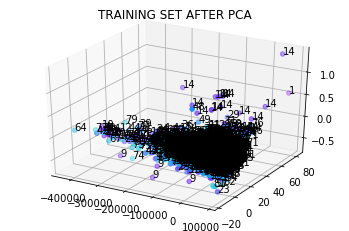

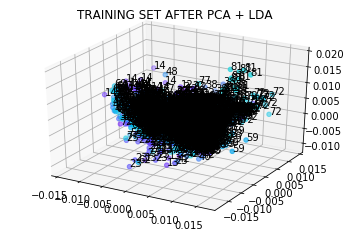

In [4]:
### PCA ###

# MEAN VECTOR
mean_vector = training_set.mean(1).reshape(n_features,1)
centered_train_set = training_set - np.repeat(mean_vector,train_set_samples,axis=1)

# COVARIANCE MATRIX
cov_matrix = np.cov(centered_train_set)

# EIGEN VALUES AND EIGEN VECTORS
eigen_values,eigen_vectors = np.linalg.eig(cov_matrix)
sorted_indexes = np.argsort(eigen_values)[::-1]
eigen_values = eigen_values[sorted_indexes]
eigen_vectors = eigen_vectors[:,sorted_indexes]

# PROJECTION INTO PRINCIPAL COMPONENTS
components_PCA = 40

projected_train_set = np.dot(eigen_vectors[:,0:components_PCA].T , centered_train_set)


# SCATTER OF PROJECTED TRAIN SET
fig = plt.figure()
ax = plt.axes(projection = "3d")
colors = cm.rainbow(train_set_labels)
ax.scatter(projected_train_set[0,:],projected_train_set[1,:],projected_train_set[2,:],color=colors)
for i in range(0,train_set_samples):
    ax.text(projected_train_set[0,i],projected_train_set[1,i],projected_train_set[2,i],str(train_set_labels[i]))

plt.title("TRAINING SET AFTER PCA")

plt.show()


### LDA ###
tot_classes = np.unique(train_set_labels).shape[0]

means = [None] * tot_classes
covariances = [None] * tot_classes
Sb = [None] * tot_classes

for i in range(0,tot_classes):
    means[i] = projected_train_set[:,train_set_labels == (i+1)].mean(1).reshape(-1,1)
    covariances[i] = np.cov(projected_train_set[:,train_set_labels == (i+1)])

SW = np.zeros((projected_train_set.shape[0],projected_train_set.shape[0]));
for i in range(0,tot_classes):
    SW += covariances[i]

means_sum = np.zeros((projected_train_set.shape[0],1))
for i in range(0,tot_classes):
    means_sum+=means[i]
Mu = means_sum/tot_classes

for i in range(0,tot_classes):
    Sb[i] = projected_train_set[:,train_set_labels == (i+1)].shape[1] * np.dot((means[i] - Mu),(means[i] - Mu).T)

SB = np.zeros((Sb[0].shape[0],Sb[0].shape[0]))
for i in range(0,tot_classes):
    SB += Sb[i]

MA = np.dot(np.linalg.inv(SW),SB)

# EIGEN VALUES AND EIGEN VECTORS
eigen_values_LDA,W = np.linalg.eig(MA)
sorted_indexes = np.argsort(eigen_values_LDA)[::-1]
eigen_values_LDA = eigen_values_LDA[sorted_indexes]
W = W[:,sorted_indexes]

# PROJECTION TO PRINCIPAL DISCRIMINATIVE COMPONENTS
components_LDA = 30
LDA_train_set = np.dot(W[:,0:components_LDA].T,projected_train_set)

# SCATTER OF TRAIN SET AFTER LDA
fig = plt.figure()
ax = plt.axes(projection = "3d")
colors = cm.rainbow(train_set_labels)
ax.scatter(LDA_train_set[0,:],LDA_train_set[1,:],LDA_train_set[2,:],color=colors)
for i in range(0,train_set_samples):
    ax.text(LDA_train_set[0,i],LDA_train_set[1,i],LDA_train_set[2,i],str(train_set_labels[i]))

plt.title("TRAINING SET AFTER PCA + LDA")

plt.show()

### Classification functions

In [5]:
def KNN(train_set,train_set_labels,test_point,k):
    if k > train_set.shape[1]:
        print("K must be less than the available points");return

    if train_set.shape[1] != train_set_labels.shape[0]:
        print("Labels don't match the samples");return


    distance_vector = np.zeros(train_set.shape[1])
    for i in range(0,train_set.shape[1]):
        distance_vector[i] = distance.euclidean(test_point , train_set[:,i])

    sorted_indexes = np.argsort(distance_vector)
    indexes_k_nearest = sorted_indexes[0:k]
    labels_k_nearest = train_set_labels[indexes_k_nearest]

    return stats.mode(labels_k_nearest)[0][0]
        

def wKNN(train_set,train_set_labels,test_point,k):
    if k > train_set.shape[1]:
        print("K must be less than the available points");return

    if train_set.shape[1] != train_set_labels.shape[0]:
        print("Labels don't match the samples");return


    distance_vector = np.zeros(train_set.shape[1])
    for i in range(0,train_set.shape[1]):
        distance_vector[i] = distance.euclidean(test_point , train_set[:,i])

    WL = np.array([1./distance_vector,train_set_labels])

    sorted_indexes = np.argsort(distance_vector)
    indexes_k_nearest = sorted_indexes[0:k]
    k_n = WL[:,indexes_k_nearest]

    unique_classes = np.unique(k_n[1,:])
    wf = np.zeros(unique_classes.shape[0])

    for i in range(0,unique_classes.shape[0]):
        indexes_of_w = k_n[1,:] == unique_classes[i]
        wf[i] = np.sum(k_n[0,indexes_of_w])

    return unique_classes[np.argmax(wf)]

### Classification with KNN and wKNN

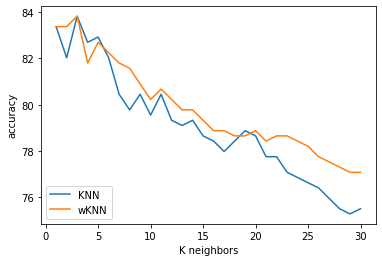

In [6]:
# PROJECT THE TEST
centered_test_set = test_set - np.repeat(mean_vector,test_set.shape[1],axis=1)
projected_test_set = np.dot(eigen_vectors[:,0:components_PCA].T,centered_test_set);

#CLASSIFICATION USING KNN
neighbors = 30;

accuracy = np.zeros(neighbors)

for k in range(0,neighbors):

    correct = 0
    wrong = 0

    for i in range(0,test_set.shape[1]):
        classification = KNN(LDA_train_set,train_set_labels,np.dot(W[:,0:components_LDA].T,projected_test_set[:,i]),k+1)
        if classification == test_set_labels[i]:
            correct+=1
        else :
            wrong+=1
    accuracy[k]=(correct/(correct + wrong))*100;


plt.plot(range(1,neighbors+1),accuracy,label='KNN')
plt.xlabel("K neighbors")
plt.ylabel("accuracy")


#CLASSIFICATION USING wKNN
accuracy = np.zeros(neighbors)

for k in range(0,neighbors):

    correct = 0
    wrong = 0

    for i in range(0,test_set.shape[1]):
        classification = wKNN(LDA_train_set,train_set_labels,np.dot(W[:,0:components_LDA].T,projected_test_set[:,i]),k+1)
        if classification == test_set_labels[i]:
            correct+=1
        else :
            wrong+=1
    accuracy[k]=(correct/(correct + wrong))*100;

plt.plot(range(1,neighbors+1),accuracy,label='wKNN')
plt.legend(loc='lower left')
plt.show()

## INTERFACE TO FEED TO THE MODEL UNSEEN BOOKS OF AUTHORS IN THE DATASET

In [7]:
def classify(path,k):
    test_book = extract_features(path).reshape(-1,1)
    centered_test_book = test_book - mean_vector
    projected_test_book = np.dot(eigen_vectors[:,0:components_PCA].T , centered_test_book)
    classification_KNN = KNN(LDA_train_set,train_set_labels,np.dot(W[:,0:components_LDA].T,projected_test_book),k)
    classification_wKNN = wKNN(LDA_train_set,train_set_labels,np.dot(W[:,0:components_LDA].T,projected_test_book),k)
    
    return [classification_KNN,classification_wKNN]

def get_authors():
    home_dir = os.environ["HOME"]
    authors = [authors.replace(home_dir+ "/AuthorshipRecognition/training_set/","") 
                     for authors in glob.glob(home_dir + "/AuthorshipRecognition/training_set/*")]
    authors.sort()
    return authors

def print_results(classification,authors):
    print("KNN classification result:")
    print(authors[int(classification[0])-1])
    print("wKNN classification result:")
    print(authors[int(classification[1])-1])
    print("----------------------------")

In [8]:
authors = get_authors()

In [9]:
classification = classify("additional_test_books/linnet.txt",16)
print_results(classification,authors)

classification = classify("additional_test_books/20.txt",11)
print_results(classification,authors)

classification = classify("additional_test_books/4790.txt",16)
print_results(classification,authors)

classification = classify("additional_test_books/the_river_war__by_winston_s._churchill.txt",11)
print_results(classification,authors)

KNN classification result:
Grant Allen
wKNN classification result:
Grant Allen
----------------------------
KNN classification result:
Thomas Hardy
wKNN classification result:
Thomas Hardy
----------------------------
KNN classification result:
Charles Darwin
wKNN classification result:
Charles Darwin
----------------------------
KNN classification result:
Ambrose Bierce
wKNN classification result:
Sir Richard Francis Burton
----------------------------
